In [10]:
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
from nltk import word_tokenize
from nltk.corpus import stopwords

# Exploratory data analysis 

### Load Data

In [3]:
import pandas as pd
import json
from matplotlib import pyplot as plt


with open('data_full.json') as json_file: 
    data_dict = json.load(json_file) 



#### Separate data by Type 
Separating data by Type and cast as a dataFrame

In [4]:
train_data = data_dict['train'] # Data (In scoop) for traning
val_data = data_dict['val'] # Data (In scoop) for validation
test_data = data_dict['test'] # Data (In scoop) for test

oos_train = data_dict['oos_train'] # Data  (Out of scoop)for traning 
oos_val = data_dict['oos_val'] # Data (Out of Scoop) for validation
oos_test = data_dict['oos_test'] # Data (Out of Scoop) for testing


train_df = pd.DataFrame(train_data, columns =['query', 'intent'])
val_df = pd.DataFrame(val_data, columns =['query', 'intent'])
test_df = pd.DataFrame(test_data, columns =['query', 'intent'])

# concatenating validation and train set
frames = [train_df,val_df]
train_val_df = pd.concat(frames)

print(train_df.head())
# grouping
#train_df.groupby("intent").count().to_excel('ds_grouped.xlsx',sheet_name="Sheet1")

                                               query     intent
0  what expression would i use to say i love you ...  translate
1  can you tell me how to say 'i do not speak muc...  translate
2  what is the equivalent of, 'life is good' in f...  translate
3  tell me how to say, 'it is a beautiful morning...  translate
4  if i were mongolian, how would i say that i am...  translate


## About the Data

The paper related to this dataset is from November 2018, so the genre of the dataset is modern and the language used is English. The data was collected using a scoping crowdsourcing task that prompted crowd workers to provide questions and commands related to topic domains in the manner they would interact with an artificially intelligent assistant. The data was manually grouped into intent classes with guidance from these queries.





#### In Scope
The provided dataset contains 23,700 queries, including 22,500 in-scope queries covering 150 intents, which can be grouped into 10 general domains. Each intent has 100 training queries, which is representative of what a team with a limited budget could gather while developing a task-driven dialog system. Along with the 100 training queries, there are 20 validation and 30 testing queries per intent. This balanced approach ensures that the dataset is comprehensive and realistic, providing a more rigorous benchmark for text classification in task-oriented dialog systems. 


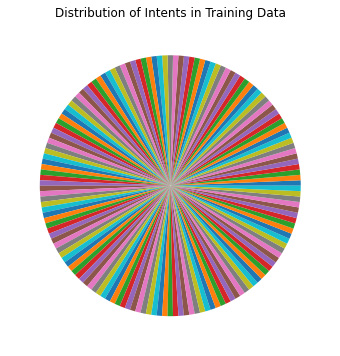

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Count the number of queries per intent in the training data
intent_counts = train_df['intent'].value_counts()

# Create a pie chart of the distribution of each intent in the training data
plt.figure(figsize=(10, 6))
plt.pie(intent_counts.values, labels= None, )

# Set the title and axis labels
plt.title('Distribution of Intents in Training Data')

# Display the chart
plt.show()

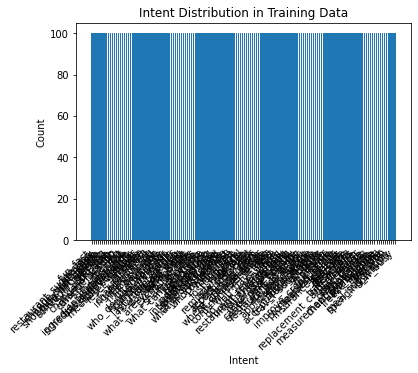

In [7]:
# Count the number of queries per intent in the training data
intent_counts = train_df['intent'].value_counts()

# Create a bar chart of the intent distribution in the training data
plt.bar(intent_counts.index, intent_counts.values)

# Set the title and axis labels
plt.title('Intent Distribution in Training Data')
plt.xlabel('Intent')
plt.ylabel('Count')

# Display the chart
plt.xticks(rotation= 45, ha='right')
plt.show()

#### Out of Scoop
The dataset also included 1,200 out-of-scope queries. Of the 1,200 out-of-scope queries collected, 100 are used for validation and 100 are used for training, leaving 1,000 for testing.

In [ ]:
plt.pie([len(train_data), len(oos_train)],labels=['In-scope', 'Out-of-scope'])
plt.legend(loc='upper right')
plt.show()

Therefore, the dataset is very balanced between in-scope intent classes. Instead, it's very unbalanced between in-scope and out-of-scope training samples because we have 15,000 in-scope queries and only 100 out-of-scope queries. But if we consider out-of-scope as an intent class we have a dataset with 151 intents and very balanced.

#### Concatenate validation and train set


In [16]:

""""
intent_class=["fun_fact","replacement_card_duration","time","maybe","car_rental"]

fun_fact = train_val_df[train_val_df['intent']==intent_class[0]]
fun_fact_list = fun_fact['query'].tolist()


vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(fun_fact_list).toarray()



tokens_list = []
wordcloud = WordCloud().generate(" ".join(fun_fact_list))
tokens = word_tokenize(" ".join(fun_fact_list))
tokens_list=[w for w in tokens if w not in list(stopwords.words('english'))]
c = Counter(tokens_list)
most_common = c.most_common(10)

print("Number of types:",len(set(tokens_list)))
print("Most common type:",most_common)

feats = [feat[0] for feat in most_common]
counts = [count[1] for count in most_common]

plt.bar(feats,counts)
plt.xticks(rotation=30, ha='right')


plt.figure()
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
"""



## Content anlysis 

### Pre-Processing 
The dataset is already partially pre-processed : all words are down cased and punctuations is removed. So we just need to remove special characters and lemmatize.

We can just pass the pre-processing function as argument to the vectorizer and then it will be applied to each word of the corpus analyzed by the vectorizer.

##### Our Pre-processing function 

In [49]:
from nltk.stem import WordNetLemmatizer
import re

def preProcess(w):
    lemmatizer = WordNetLemmatizer()
    w = re.sub('[^a-zA-Z]', ' ', w)
    return lemmatizer.lemmatize(w)

## Words analysis 
Plot a mini report, graph and word cloud with the more relevant words of ech class

In [52]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from operator import itemgetter

def plot_top_n(corpus,keys, a_class, vectorizer, n):

    idx = keys.index(a_class)
    X = vectorizer.fit_transform(corpus).toarray()
    feat_val = list(zip(vectorizer.get_feature_names_out(), X[idx]))
    feat_val.sort(key=itemgetter(1), reverse=True)
    

    feat_val_top_n = feat_val[:n-1]
    feat_val_sep = list(zip(*feat_val_top_n))
    
    if type(vectorizer) == type(CountVectorizer()):
        vect = 'BAG OF WORDS'
    else :
        vect = 'TF-IDF'

    plt.figure(figsize=(10,5))
    plt.suptitle(f'{vect} - {a_class}')
    plt.subplot(1,2,1)

    # plot's labels
    plt.xlabel("More relavant words")
    plt.ylabel("number of apperances")

    # format the x values 
    plt.bar(feat_val_sep[0],feat_val_sep[1])
    plt.xticks(rotation=30, ha='right')
    
    # Word Cloud
    word_list = [x for x in (" ".join(corpus)).split() if x != "ssss"]
    wordcloud = WordCloud().generate(" ".join(word_list))
    plt.subplot(1,2,2)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()


### Plot most relevant words
 Print a report with the most relevant words of each intent

c:\Users\comas\venvpy3107\lib\site-packages\sklearn\feature_extraction\text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['doe', 'ha', 'wa'] not in stop_words.
  warnings.warn(


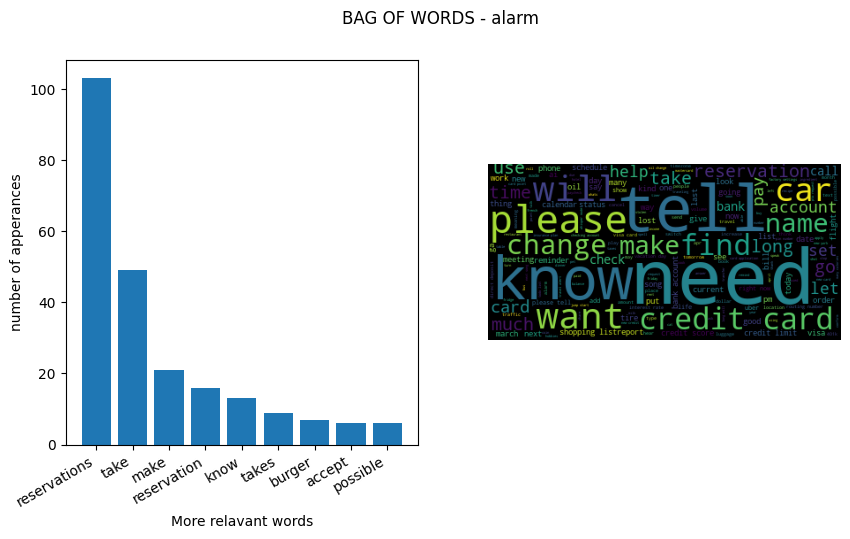

c:\Users\comas\venvpy3107\lib\site-packages\sklearn\feature_extraction\text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['doe', 'ha', 'wa'] not in stop_words.
  warnings.warn(


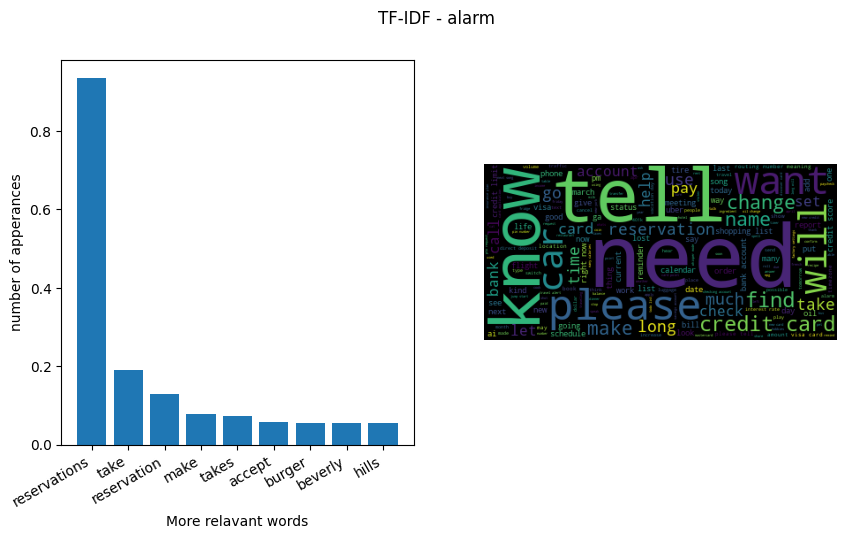

c:\Users\comas\venvpy3107\lib\site-packages\sklearn\feature_extraction\text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['doe', 'ha', 'wa'] not in stop_words.
  warnings.warn(


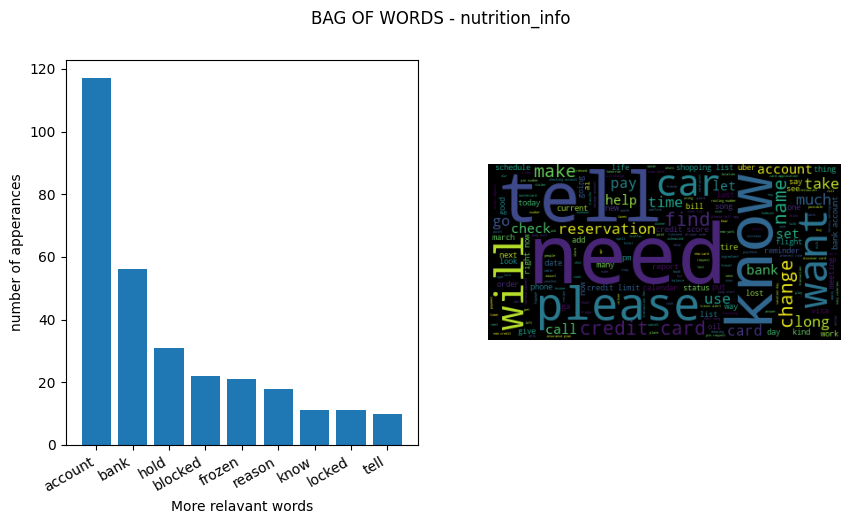

c:\Users\comas\venvpy3107\lib\site-packages\sklearn\feature_extraction\text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['doe', 'ha', 'wa'] not in stop_words.
  warnings.warn(


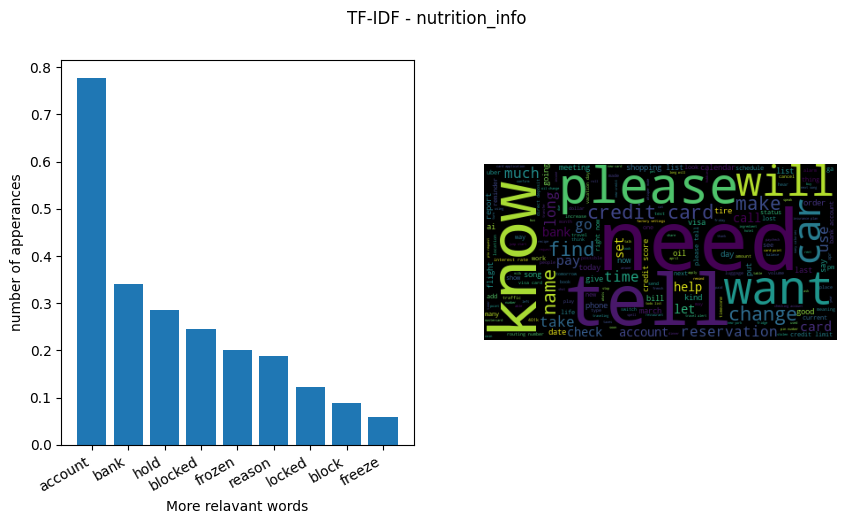

In [53]:


intents = train_val_df.groupby('intent')['query'].apply(lambda x: " ".join(x))
keys = ['alarm','nutrition_info']
values = list(intents.values)

intents_n = train_val_df.groupby('intent')['query'].apply(lambda x: "ssss " + " ssss ".join(x) + " ssss")
keys_n = list(intents_n.keys())
values_n = list(intents_n.values)

for intent in keys:
    
    n = 10

    plot_top_n(values, keys,intent, CountVectorizer(ngram_range=(1,1), preprocessor=preProcess, stop_words=stop_words), n)
    plot_top_n(values,keys, intent, TfidfVectorizer(ngram_range=(1,1), preprocessor=preProcess, stop_words=stop_words), n)


### Grouping by domains:
Insted of using all the 150 intent classes (151 if include the out of scoop) grup the intents classes by theirs domain, forming a data set with 10 classes

#### Load the domains from the jason 

In [ ]:
with open('domains.json') as json_file:
    domain_dict = json.load(json_file)
#print(inv_domain_dict)
print(domain_dict)

#### Group intents by domain 
Each domain have 10 intent classes, what we are doing here is group all the intents of a domain into a single "class".

In [ ]:
#unigram
intent_domains_unigram = train_val_df.set_index('intent').groupby(inv_domain_dict, group_keys=True)['query'].apply(lambda x: " ".join(x))
keys_unigram = list(intent_domains_unigram.keys())
values_unigram = list(intent_domains_unigram.values)

# n-gram
intent_domains_n_gram = train_val_df.set_index('intent').groupby(inv_domain_dict, group_keys=True)['query'].apply(lambda x: "ssss " + " ssss ".join(x) + " ssss")
keys_n_gram = list(intent_domains_n_gram.keys())
values_n_gram = list(intent_domains_n_gram.values)


#### Plot more relevant words for each domain

In [ ]:


for domain in domain_dict.keys():
    
    n = 10 # number of n more relevant words 
    n_gram = 2 # number of n-grams
    print("###################################################################################################")
    print(f"                                          {domain.upper()}")
    print("###################################################################################################")
    print("                                      ###UNIGRAM###")
    print(f"For the domain '{domain}' the top {n} unigrams have the following counts and TF-IDF scores:")
    plot_top_n(values_unigram, domain, CountVectorizer(ngram_range=(1,1), preprocessor=preProcess, stop_words=stop_words), n)
    plot_top_n(values_unigram, domain, TfidfVectorizer(ngram_range=(1,1), preprocessor=preProcess, stop_words=stop_words, use_idf=True), n)

   
    print(f"                                     ###'{n_gram}'-GRAM###")
    print(f"For the domain '{domain}' the top {n} {n_gram}-grams have the following counts and TF-IDF scores:")
    plot_top_n(values_n_gram, domain, CountVectorizer(ngram_range=(n_gram,n_gram),preprocessor=preProcess, stop_words=stop_words), n)
    plot_top_n(values_n_gram, domain, TfidfVectorizer(ngram_range=(n_gram,n_gram), preprocessor=preProcess, stop_words=stop_words, use_idf=True), n)